In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

# Loading data

In [2]:
X_data = pd.read_csv('data/train_data.csv')
X_data_test = pd.read_csv('data/1234.csv', sep=';')
X_data_ktest = pd.read_csv('data/test_data.csv')
y_data = pd.read_csv('data/train_target.csv', header=-1, names=['agreed'])

In [3]:
y_data_test = X_data_test['y']
X_data_test.drop(['y'], axis = 1, inplace = True, errors = 'ignore')

y_data_test = pd.DataFrame(y_data_test)
y_data_test['y'] = y_data_test.apply(lambda row: 1 if row['y'] == 'yes' else 0, axis=1)

In [4]:
print('Is everything ok?: ',  X_data.shape[0] == y_data.shape[0])
print('And duplicates?: ',  np.all(X_data.duplicated() == False))

Is everything ok?:  True
And duplicates?:  False


Checking if balanced sample:


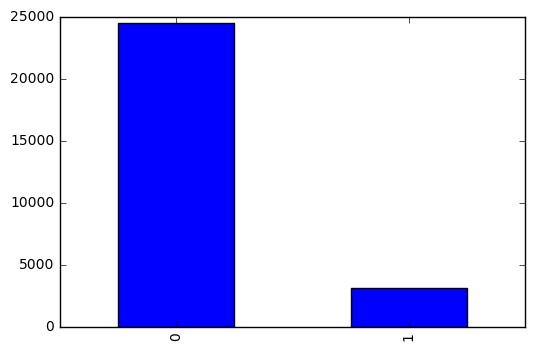

In [5]:
print('Checking if balanced sample:')
y_data['agreed'].value_counts().plot(kind='bar');

# Working with features

In [6]:
X_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.00000
mean,40.085994,258.874542,2.568328,962.693169,0.172024,0.087211,93.577443,-40.503026,3.628844,5167.31696
std,10.480548,260.511236,2.765561,186.371948,0.492548,1.567343,0.578193,4.616641,1.730084,72.22960
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.60000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.10000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.00000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.10000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.10000


In [7]:
def convert_features(data):
    conv_data = data.copy()
    
    conv_data['default'] = conv_data.apply(lambda row: 1 if row['default'] == 'yes' else 0, axis=1)
    
    conv_data['housing'] = conv_data.apply(lambda row: 1 if row['housing'] == 'yes' else 0, axis=1)
    
    conv_data['loan'] = conv_data.apply(lambda row: 1 if row['loan'] == 'yes' else 0, axis=1)
    
    # nominal values
    nom_df = conv_data[['poutcome', 'month', 'contact',
                        'education', 'day_of_week', 'job', 'marital']]
    conv_data = conv_data.drop(nom_df.columns, axis=1)
    nom_df = pd.get_dummies(nom_df)
    conv_data = pd.concat([conv_data, nom_df], axis = 1)
    
    # drop unused
    conv_data = conv_data.drop(['previous'], axis = 1)
    
    return conv_data

In [8]:
X_data = convert_features(X_data)

# Undersampling major feature

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
X_cols = X_data.columns

In [11]:
# smote = SMOTE(ratio='auto', kind='regular')
# X_data, y_data = smote.fit_sample(X_data, y_data['agreed'].values.ravel())

In [12]:
X_data = pd.DataFrame(X_data)
X_data.columns = X_cols
y_data = pd.DataFrame(y_data)
y_data.columns = ['agreed']

In [13]:
X_data.shape

(27595, 56)

In [14]:
RUS = RandomUnderSampler()
X_data, y_data = RUS.fit_sample(X_data, y_data['agreed'].values.ravel())

In [15]:
X_data = pd.DataFrame(X_data)
X_data.columns = X_cols
y_data = pd.DataFrame(y_data)
y_data.columns = ['agreed']

In [16]:
X_data.shape

(6228, 56)

# And updating test samples

In [17]:
X_data_test = convert_features(X_data_test)

In [18]:
X_data_ktest = convert_features(X_data_ktest)

# PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
# pca = PCA(n_components=5)
# pca.fit(X_data)
# X_data = pca.transform(X_data)
# X_data_test = pca.transform(X_data_test)
# X_data_ktest = pca.transform(X_data_ktest)
# X_data = pd.DataFrame(X_data)
# X_data_ktest = pd.DataFrame(X_data_ktest)


In [21]:
# X_data.hist(figsize=(15, 15));

In [22]:
X_data.corrwith(y_data['agreed'])

age                              3.869479e-02
default                                   NaN
housing                          2.379998e-02
loan                             5.505502e-03
duration                         4.616757e-01
campaign                        -1.326044e-01
pdays                           -3.110566e-01
emp.var.rate                    -4.387896e-01
cons.price.idx                  -2.057798e-01
cons.conf.idx                    6.395715e-02
euribor3m                       -4.542277e-01
nr.employed                     -4.690636e-01
poutcome_failure                 5.470176e-02
poutcome_nonexistent            -2.622264e-01
poutcome_success                 2.998052e-01
month_apr                        1.100315e-01
month_aug                       -2.372463e-02
month_dec                        8.503533e-02
month_jul                       -3.757807e-02
month_jun                       -1.385046e-02
month_mar                        1.433583e-01
month_may                       -1

# Splitting data into train/test sets

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
RANDOM_SEED = 34791
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data['agreed'].values, test_size=0.25, 
                 random_state = RANDOM_SEED, stratify=y_data['agreed'].values)

# Fitting models

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [26]:
def top_importance_print(n, importances, importances_names):
    indexes = importances.argsort()[-n:][::-1]
    for i, index in enumerate(indexes):
        print ('#{} Important feature is -- {} with {:.2f} importance'.format(i + 1, importances_names[index], importances[index]))

In [27]:
def write_to_submission_file(predicted_labels, out_file='output.csv',
                             target='Prediction', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [43]:
class ModelTester():
    def __init__(self, parameters, model, scoring='roc_auc', njobs=-1, cv=3):
        self.cv = GridSearchCV(model, parameters, scoring = scoring, n_jobs = njobs, cv = cv, verbose = 1)
    
    def test_model(self):
        self.cv.fit(X_train, y_train);
        print('Best score cv: ', self.cv.best_score_)
        print('Params: ', self.cv.best_params_)
    
        y_predicted = self.cv.predict(X_test)
        print('Score on test sample:', roc_auc_score(y_test, y_predicted))
    
        y_predicted = self.cv.predict(X_data_test)
        print('Score on full sample:', roc_auc_score(y_data_test['y'].values, y_predicted))
        
    def best_estimator(self):
        return self.cv.best_estimator_
    

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced']}

mt = ModelTester(parameters = param, model = RandomForestClassifier())
mt.test_model()
clf = mt.best_estimator()

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:    6.2s finished


Best score cv:  0.932258257235
Params:  {'max_features': 'auto', 'max_depth': 16, 'criterion': 'entropy', 'class_weight': 'balanced'}
Score on test sample: 0.874777663011
Score on full sample: 0.893734562106


## SVC

In [49]:
from sklearn.svm import SVC

In [50]:
param = {'C': np.linspace(0.01, 0.03, num=5), 
              'class_weight':['balanced'], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None], 'random_state' : [RANDOM_SEED], 
              'class_weight' : [None, {1: 10}]}
mt = ModelTester(parameters = param, model = SVC())
mt.test_model()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.7min finished


Best score cv:  0.933476626478
Params:  {'random_state': 34791, 'decision_function_shape': 'ovo', 'class_weight': None, 'kernel': 'linear', 'C': 0.014999999999999999}
Score on test sample: 0.854210460316
Score on full sample: 0.856944823152


## AdaBoostClassifier

In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}
mt = ModelTester(parameters = param, model = AdaBoostClassifier())
mt.test_model()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.9s finished


Best score cv:  0.935266579523
Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6}
Score on test sample: 0.877338457122
Score on full sample: 0.871701939915


## DecisionTreeClassifier

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RANDOM_SEED], 'presort':[True, False]}
mt = ModelTester(parameters = param, model = DecisionTreeClassifier())
mt.test_model()

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best score cv:  0.823594414949
Params:  {'max_features': 'auto', 'random_state': 34791, 'presort': True, 'splitter': 'best', 'class_weight': 'balanced', 'criterion': 'gini'}
Score on test sample: 0.815661598978
Score on full sample: 0.866696536062


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    1.8s finished


# KNeighborsClassifier

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
param = {'n_neighbors': [30, 50, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [20, 30, 50], 'p':[1, 2]}
mt = ModelTester(parameters = param, model = KNeighborsClassifier())
mt.test_model()

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.3min finished


Best score cv:  0.935598208625
Params:  {'n_neighbors': 50, 'p': 1, 'algorithm': 'ball_tree', 'weights': 'distance', 'leaf_size': 20}
Score on test sample: 0.872837267474
Score on full sample: 0.897701381367


# GradientBoostingClassifier

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
param = {'loss': ['deviance', 'exponential'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3] }
mt = ModelTester(parameters = param, model = GradientBoostingClassifier())
mt.test_model()

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   44.6s finished


Best score cv:  0.944885001379
Params:  {'max_features': 'auto', 'loss': 'exponential', 'min_samples_leaf': 3, 'presort': False, 'n_estimators': 300}
Score on test sample: 0.891483049589
Score on full sample: 0.895161841961


# XGBoost

In [59]:
from xgboost.sklearn import XGBClassifier
import math

In [60]:
clf = XGBClassifier()

In [61]:
parameters = {
        'max_depth': [1, 2, 3],
        'n_estimators': [4, 5, 6]
    }
# clf = GridSearchCV(clf, parameters, n_jobs=1, cv=3, scoring="roc_auc")

In [62]:
cv.fit(X_train, y_train);

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x113c0e940>>
Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=34791, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4, 5, 'log2', 'auto'], 'class_weight': ['balanced'], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 8, 16, 32, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)